## TEST

In [126]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype

from toolbox_ML import (
    describe_df,
    tipifica_variables,
    get_features_num_regression,
    plot_features_num_regression,
    get_features_cat_regression,
    plot_features_cat_regression,
)



In [127]:
# Cargar dataset
df = pd.read_csv("./data/dataset_viajes_jun23.csv")

df.head()

,aircompany,origen,destino,distancia,avion,con_escala,consumo_kg,duracion,ingresos,id_vuelo,mes
0,Airnar,París,Ginebra,411,Boeing 737,False,1028.691900,51,14232.65,Air_PaGi_10737,Jun23
1,FlyQ,Bali,Roma,12738,Boeing 737,True,33479.132544,1167,468527.19,Fly_BaRo_10737,Jun23
2,TabarAir,Ginebra,Los Angeles,9103,Airbus A380,False,109439.907200,626,584789.19,Tab_GiLo_11380,Jun23
3,MoldaviAir,París,Cincinnati,6370,Boeing 737,False,17027.010000,503,233342.51,Mol_PaCi_10737,Jun23
4,TabarAir,Cincinnati,Roma,7480,Boeing 747,False,86115.744000,518,438535.07,Tab_CiRo_10747,Jun23


In [128]:
# ============================================
# TEST 1: describe_df
# ============================================

tabla_desc = describe_df(df)

print("Shape de la tabla devuelta:", tabla_desc.shape)
display(tabla_desc)

# Comprobaciones visuales:
# - Debes ver una fila por "tipo de info" (DATA_TYPE, MISSINGS, UNIQUE_VALUES, CARDIN)
# - Las columnas deben ser las columnas del dataframe original.


Shape de la tabla devuelta: (4, 11)


COL_N,aircompany,origen,destino,distancia,avion,con_escala,consumo_kg,duracion,ingresos,id_vuelo,mes
DATA_TYPE,object,object,object,int64,object,bool,float64,int64,float64,object,object
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UNIQUE_VALUES,5,11,11,45,4,2,501,113,600,347,1
CARDIN (%),0.83,1.83,1.83,7.5,0.67,0.33,83.5,18.83,100.0,57.83,0.17


In [129]:
# ============================================
# TEST 2: tipifica_variables
# ============================================

# Elegimos unos umbrales razonables
umbral_categoria = 10    # si tiene < 10 valores únicos → Categórica
umbral_continua  = 0.30  # si CARDIN (%) >= 30 → Numérica continua

tipos = tipifica_variables(df, umbral_categoria, umbral_continua)

print("Shape del dataframe de tipos:", tipos.shape)
display(tipos)

# Cosas a mirar:
# - Debe tener tantas filas como columnas tenga df.
# - Debe haber 2 columnas: "nombre_variable" y "tipo_sugerido".
# - Revisa que 'Country' salga como Categórica y el resto como Numérica continua/discreta según cardinalidad.


Shape del dataframe de tipos: (11, 2)


,nombre_variable,tipo_sugerido
0,aircompany,Numérica continua
1,origen,Numérica continua
2,destino,Numérica continua
3,distancia,Numérica continua
4,avion,Numérica continua
5,con_escala,Numérica continua
6,consumo_kg,Numérica continua
7,duracion,Numérica continua
8,ingresos,Numérica continua
9,id_vuelo,Numérica continua


In [130]:
def tipifica_variables(df, umbral_categoria, umbral_continua):
    """
    Clasifica variables según su cardinalidad.

    Reglas:
    - 2 valores únicos -> 'Binaria'
    - cardinalidad < umbral_categoria -> 'Categórica'
    - cardinalidad >= umbral_categoria:
        * si (cardinalidad / n_filas) >= umbral_continua -> 'Numerica Continua'
        * si no -> 'Numerica Discreta'
    """

    resultados = []
    n_filas = len(df)

    for col in df.columns:
        serie = df[col]
        cardinalidad = serie.nunique(dropna=True)

        if cardinalidad == 2:
            tipo = "Binaria"
        elif cardinalidad < umbral_categoria:
            tipo = "Categórica"
        else:
            # cardinalidad >= umbral_categoria => miramos % cardinalidad
            pct_card = (cardinalidad / n_filas) if n_filas > 0 else 0

            if pct_card >= umbral_continua:
                tipo = "Numerica Continua"
            else:
                tipo = "Numerica Discreta"

        resultados.append({"nombre_variable": col, "tipo_sugerido": tipo})

    return pd.DataFrame(resultados)


In [131]:
df = pd.read_csv("./data/dataset_viajes_jun23.csv")
tipos = tipifica_variables(df, umbral_categoria=10, umbral_continua=0.3)
print(tipos)


   nombre_variable      tipo_sugerido
0       aircompany         Categórica
1           origen  Numerica Discreta
2          destino  Numerica Discreta
3        distancia  Numerica Discreta
4            avion         Categórica
5       con_escala            Binaria
6       consumo_kg  Numerica Continua
7         duracion  Numerica Discreta
8         ingresos  Numerica Continua
9         id_vuelo  Numerica Continua
10             mes         Categórica


get_features_num_regression → Selecciona las columnas numéricas que están correladas con el target.

In [132]:
# ====================================================
# TEST 3: get_features_num_regression
# ====================================================

# 1. Definimos parámetros del test
target = "ingresos"      # variable objetivo numérica
umbral_corr = 0.3        # umbral de correlación mínima
pvalue = 0.05            # nivel de significación (opcional)

# 2. Llamamos a la función
cols_sel = get_features_num_regression(
    df,
    target_col=target,
    umbral_corr=umbral_corr,
    pvalue=pvalue
)

print("Columnas seleccionadas por get_features_num_regression:")
print(cols_sel)

# 3. Comprobaciones rápidas
print("\nTipo devuelto:", type(cols_sel))
if isinstance(cols_sel, list):
    print("Número de columnas seleccionadas:", len(cols_sel))
    print("¿Todas las columnas existen en el DataFrame?",
          all(c in df.columns for c in cols_sel))


Columnas seleccionadas por get_features_num_regression:
['distancia', 'consumo_kg', 'duracion']

Tipo devuelto: <class 'list'>
Número de columnas seleccionadas: 3
¿Todas las columnas existen en el DataFrame? True


Cosas a revisar a mano:  
Debe devolver una LISTA de nombres de columnas (o None si hay error de argumentos).  
Todas las columnas de la lista deben ser numéricas: distancia, consumo_kg, duracion, ingresos...  
(ingresos no saldrá porque es el target).  
Prueba a cambiar el umbral:  
umbral_corr = 0.1  -> deberían aparecer más columnas.  
umbral_corr = 0.5  -> deberían quedar menos.  
Prueba pvalue=None para ver que, en general, salen igual o más columnas.  

Columnas que se van a representar en el pairplot:
['distancia', 'consumo_kg', 'duracion']


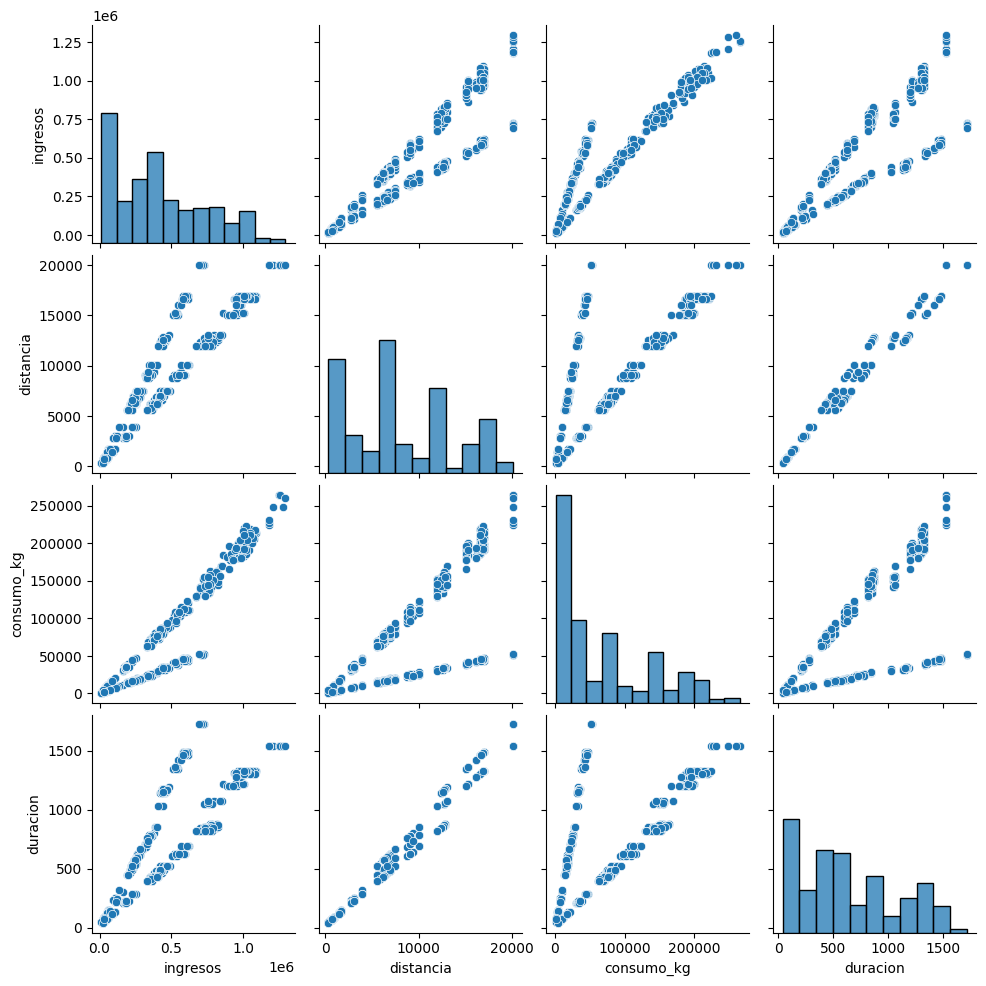

['distancia', 'consumo_kg', 'duracion']

In [133]:
# ====================================================
# TEST 4: plot_features_num_regression
# ====================================================

# Si por alguna razón cols_sel es None o lista vacía,
# puedes elegir manualmente algunas columnas numéricas:
if not cols_sel:
    cols_plot = ["distancia", "consumo_kg", "duracion"]
else:
    cols_plot = cols_sel

print("Columnas que se van a representar en el pairplot:")
print(cols_plot)

# 1. Llamamos a la función de gráficos
plot_features_num_regression(
    df,
    target_col=target,      # "ingresos"
    columns=cols_plot,      # lista de columnas numéricas
    umbral_corr=umbral_corr,
    pvalue=pvalue
)


plot_features_num_regression → Dibuja pairplots del target con esas columnas.

📝 Qué revisar manualmente  
La función debe devolver una LISTA (o None si hay error en argumentos).  
Las columnas seleccionadas deben ser siempre numéricas:  
distancia  
consumo_kg  
duracion  
(no debe aparecer el target “ingresos”)  
Si reduces el umbral (umbral_corr = 0.1), deberían aparecer más columnas.  
Si aumentas el umbral (umbral_corr = 0.5), deberían aparecer menos.  
Cambiar pvalue=None debería devolver igual o más columnas, ya que no aplica la restricción de significación.  

['consumo_kg', 'duracion', 'ingresos']


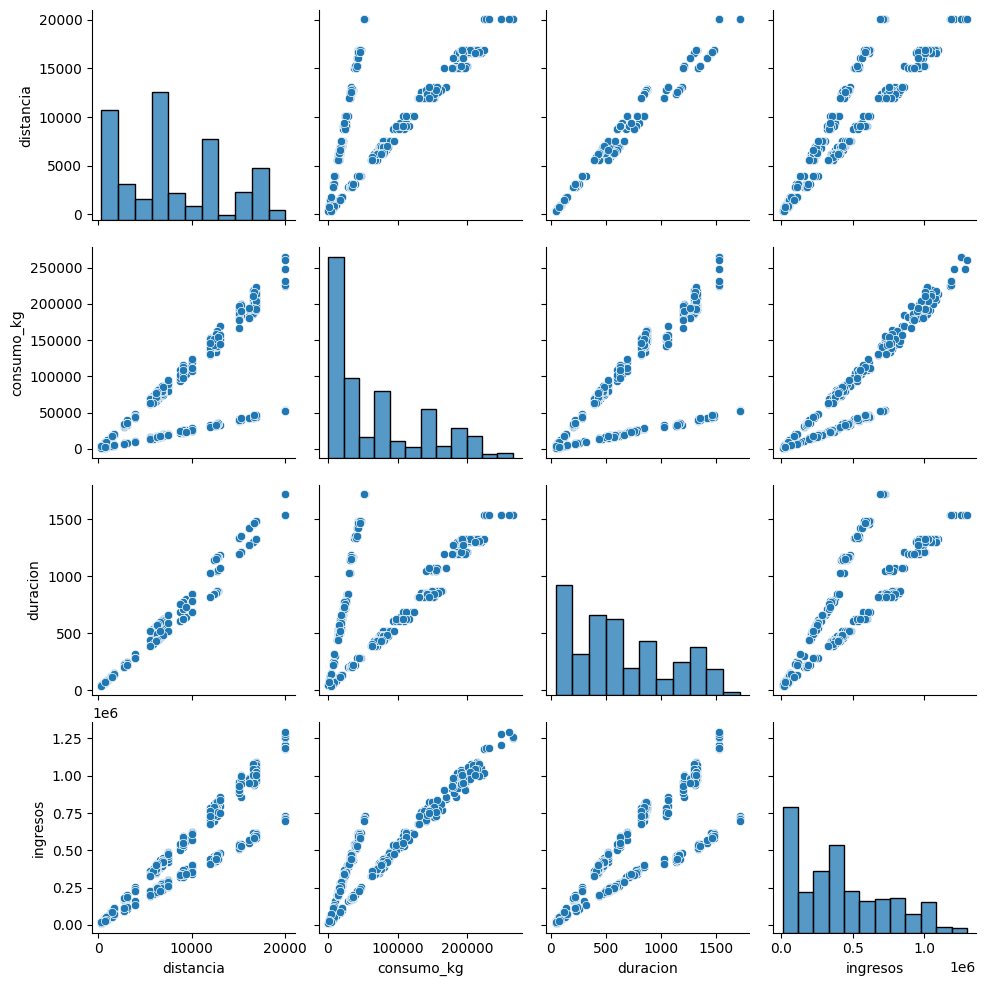

['consumo_kg', 'duracion', 'ingresos']

In [135]:
import pandas as pd

df = pd.read_csv("./data/dataset_viajes_jun23.csv")

# 1. Probar selección
cols_sel = get_features_num_regression(df, "distancia", umbral_corr=0.3, pvalue=0.05)
print(cols_sel)

# 2. Probar gráficos
plot_features_num_regression(df, "distancia", [], 0.3, 0.05)
